In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score as CVS
from sklearn.preprocessing import PolynomialFeatures as PF
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse as RMSE
import scipy.stats as stats
import numbers
import pickle


In [181]:
def transform(data_t, poly=None, test=False):
    """
    poly values: 'all', 'list', 'singles', 'all_single'
    Note: singles/all_single -column names only have first letters
    
    """

    #     'bathroomsx4', 'bedrooms', 'condition', 'date', 'floorsx2', 'grade', 'lat',
#        'long', 'price', 'sqft_above', 'sqft_basement', 'sqft_living',
#         'sqft_living15', 'sqft_lot', 'sqft_lot15', 'view', 'waterfront',
#         'yr_built', 'yr_renovated', 'zipcode'
    
    to_poly = ['sqft_above', 'sqft_basement', 'sqft_living',
              'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
              'yr_renovated',]
    to_log = ['price', 'sqft_above', 'sqft_basement', 'sqft_living',
              'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
              'yr_renovated',]
    to_norm = []#['price', 'sqft_above', 'sqft_basement', 'sqft_living',
#               'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
#               'yr_renovated',]
    to_ohe = ['bedrooms', 'bathroomsx4','condition', 'floorsx2','grade','view',]
    poly_order = 2

    if poly in ['all', 'all_single']:
        to_poly = data_t.drop(to_ohe + ['price'], axis=1).columns
        if poly == 'all':
            poly = 'list'
        elif poly == 'all_single':
            poly = 'singles'
    if poly == 'list':
        poly=PF(poly_order)
        data_poly = poly.fit_transform(data_t[to_poly])
        data_poly = pd.DataFrame(data_poly)
        data_poly.columns = poly.get_feature_names(data_t[to_poly].columns)
        data_t = pd.concat([data_t.drop(to_poly, axis=1),
                            data_poly.drop('1',axis=1)], axis=1)
    elif poly == 'singles':
        for feat in to_poly:
            df = pd.DataFrame(data_t[feat])
            print(feat)
            poly=PF(poly_order)
            data_poly = poly.fit_transform(df)
            data_poly = pd.DataFrame(data_poly)
            data_poly.columns = ['drop', feat, feat + '_squared']
            data_t = pd.concat([data_t.drop(feat, axis=1), 
                                data_poly.drop('drop',axis=1)], axis=1)

    for feat in to_log:
        data_t[feat] = data_t[feat].map(lambda x: np.log(x) if x!=0 else 0)
        #Note 'if' included so that 0 values wouldn't error, will still error
        #...between 0 and 1. Also, implies that the original 0 value was a 1
        #...but as these are around values of 100s, 1000s, the effect is minimal

        
    stats = {}
    if test:
        with open('norm_stats.pickle', 'rb') as f:
            stats = pickle.load(f)
    for feat in to_norm:
        ft = data_t[feat]
        if test:
            mean = stats[feat][0]
            stdev = stats[feat][1]
        else:
            mean = np.mean(ft)
            stdev = np.sqrt(np.var(ft))
        data_t[feat] = (ft-mean) / stdev
        stats[feat] = [mean, stdev]
    with open('norm_stats.pickle', 'wb') as f:
        pickle.dump(stats, f)
        
        
    for feat in to_ohe:
        dummies = pd.get_dummies(data=data_t[feat], prefix=feat, prefix_sep='_',
                                drop_first=True)
        data_t.drop(feat, axis=1, inplace=True)
        data_t = pd.concat([data_t, dummies], axis=1)
    data_t.rename(lambda col: col.replace('.0', '').replace(' ','__')
                  .replace('^','_pow_'),
                  axis=1, inplace=True)
    
    return data_t 

#Note data_t = data.copy()   --line added as otherwise the DataFrame, data, 
#...outside of this function lost the first column mentioned in [to_ohe]

In [182]:
def simple_selector(data_s, x_cols, alpha=0.05):

    predictors = '+'.join(x_cols)
    f = 'price' + '~' + predictors
    results = ols(formula=f, data=data_s).fit()
    pv = pd.DataFrame(results.pvalues).drop('Intercept')
    pv.rename(columns={0:'p_value'}, inplace=True)
    x_cols = list(pv[pv.p_value <= alpha].index)
    
    return x_cols, pv

In [183]:
def stepwise_selector(data_s, 
                       x_cols=[], 
                       alpha=0.05, 
                       verbose=False):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        x_cols - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    
    X = data_s[x_cols]
    y = data_s['price']
    threshold_in = alpha - 0.02
    threshold_out = alpha + 0.01
    included = list(x_cols)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            results = sm.OLS(y, sm.add_constant
                             (pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = results.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        results = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = results.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, 
                                                             worst_pval))
        if not changed:
            break
            
    pv = pd.DataFrame(results.pvalues)
    pv.rename(columns={0:'p_value'}, inplace=True)
    return included, pv

## Multicollinearity Function: Remove    
The first multicollinearity function removes a feature from each pair with high multicollinearity    
This function takes in thedata, x_cols and the threshold for removing a feature

- create a dataframe of the correlation of the features in x_cols   
- transform this to get a list of pairs of features with high multicollinearity
- for each pair: check whether they are the same feature or if one of the features has already been listed to be removed; if so, continue to next pair 
- otherwise add the feature with the higher p-value to a list    
- remove the features in this list from x_cols    


return x_cols     




In [5]:
def multicoll_remove(data, x_cols, pvalues, multicollinearity_threshold):
    corr = data[x_cols].corr().abs().stack().reset_index().sort_values(0,
                                                            ascending = False)
    corr['pairs'] = list(zip(corr.level_0, corr.level_1))
    corr = corr.set_index('pairs').drop(['level_0', 'level_1'], axis=1)
    corr.columns = ['cc']
    corr = corr[corr.cc > multicollinearity_threshold]        

    to_drop = []
    for f0, f1 in corr.index:
        if (f0 == f1) | any(feat in [f0, f1] for feat in to_drop):
            continue
        to_drop.append(pvalues.loc[[f0, f1]].sort_values('p_value', 
                                                ascending=False).index[0])
    x_cols = list(set(x_cols) - set(to_drop))
    return x_cols   

In [122]:
def metrics(data_m, results, x_cols):
#     X = data[x_cols]
#     y = data.price
#     to_pred = pd.concat([y,X], axis=1)
#     yhat = results.predict(to_pred)
#     rmse = RMSE(y, yhat)
    
#     linreg = LR()
#     linreg.fit(X,y)
#     cv  = np.mean(CVS(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
#     rmse = (-cv)**0.5
      
#     print(f'RMSE: {rmse}')
    
    fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45',
                             fit=True, alpha=0.1)

    fig = plt.figure(figsize=(12,12))
    plt.scatter(data_m.price, results.resid, alpha=0.5);
    plt.hlines(0, xmax=data_m.price.max(), xmin=data_m.price.min());    

## Modelling Function
Takes in the dataframe and optional transform and multicollinearity arguments    
Checks whether to send the data to a transform function   
Selects for x_cols the features from data that are numeric, and not the price   
##### Loop

**1. Remove features with high p-values:**  
- creates the formula using x_cols     
- creates the model using formula   
- creates a dataframe, pv, of the model's p-values  
- creates a new x_cols list from the features in pv with low p-values   

**2. Handle multicollinearity:**     
- Checks whether a function has been passed for handling multicollinearity and calls accordingly    
    
         
            
            
Checks whether the length of x_cols has changed. Loop runs again if it has.     
    
    
When x_cols no longer changes, the final model and x_cols are returned





In [76]:
def modelling(datam, selector=simple_selector, transform=None, multicoll=None, 
              alpha=0.05, 
              multicollinearity_threshold = 0.7):
    
    if transform:
        datam = transform(datam)
        
    outcome = 'price'
    x_cols = [col for col in (datam.drop([outcome], axis=1).columns) 
            if isinstance(datam[col][0], numbers.Number)]
    i = 0
    while True:
        length0 = len(x_cols)
        print(f'Loop:{i}\nNumber of features: {length0}')
        
        x_cols, pvalues = selector(datam, x_cols, alpha)
        length1 = length0-len(x_cols)
        print(f'Removed by Selector: {length1}')
        
        if not i and multicoll:
            x_cols = multicoll(datam, x_cols, pvalues, 
                                      multicollinearity_threshold)
            length2 = length0 - length1 - len(x_cols)
            print(f'Removed for multicollinearity: {length2}')
        
        
        i+=1
        if len(x_cols) == length0:
            break
        
    predictors = '+'.join(x_cols)
    f = 'price' + '~' + predictors
    results = ols(formula=f, data=datam).fit()

    metrics(datam, results, x_cols)
    
    return results, x_cols

In [142]:
data_t = None


#  Model

Initial model using only cleaned data:

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     1097.
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:14:20   Log-Likelihood:                -1105.3
No. Observations:               16987   AIC:                             2311.
Df Residuals:                   16937   BIC:                             2698.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             31.4136      4.221      7.442      0.000      23.139      39.688
grade_4               -1.5210      0.067    -22.640      0.000      -1.653      -1.389
sqft_lot_pow_2      2.818e-13   1.01e-13      2.788      0.005    8.37e-14     4.8e-13
grade_5               -1.3298      0.040    -33.158      0.000      -1.408      -1.251
view_1                 0.1729      0.017     10.296      0.000       0.140       0.206
condition_5            0.1158      0.008     14.473      0.000       0.100       0.131
long                  -0.0802      0.020     -4.085      0.000      -0.119      -0.042
condition_4            0.0482      0.005      9.566      0.000       0.038       0.058
bathroomsx4_20         0.5924      0.066      8.967      0.000       0.463       0.722
lat_pow_2              0.0147      0.000     89.540      0.000       0.014       0.015
grade_9               -0.5140      0.034    -15.140      0.000      -0.581      -0.447
bathroomsx4_17         0.4819      0.035     13.585      0.000       0.412       0.551
grade_10              -0.3513      0.034    -10.331      0.000      -0.418      -0.285
bathroomsx4_31         1.3855      0.262      5.295      0.000       0.873       1.898
grade_7               -0.9491      0.035    -27.305      0.000      -1.017      -0.881
bathroomsx4_6          0.0564      0.009      5.966      0.000       0.038       0.075
bathroomsx4_12         0.2446      0.013     18.370      0.000       0.218       0.271
grade_11              -0.2237      0.035     -6.361      0.000      -0.293      -0.155
bathroomsx4_24         0.9037      0.119      7.582      0.000       0.670       1.137
bathroomsx4_25         1.2830      0.259      4.945      0.000       0.774       1.791
yr_built__zipcode  -4.111e-08   1.04e-09    -39.569      0.000   -4.31e-08   -3.91e-08
bathroomsx4_26         0.7726      0.184      4.190      0.000       0.411       1.134
bathroomsx4_18         0.4329      0.032     13.561      0.000       0.370       0.496
bathroomsx4_3         -0.0702      0.037     -1.882      0.060      -0.143       0.003
view_4                 0.2616      0.021     12.438      0.000       0.220       0.303
floorsx2_4             0.0604      0.006     10.309      0.000       0.049       0.072
condition_2           -0.1366      0.023     -5.829      0.000      -0.183      -0.091
bathroomsx4_10         0.1844      0.009     20.382      0.000       0.167       0.202
bathroomsx4_13         0.3160      0.016     20.281      0.000       0.285       0.346
bathroomsx4_15         0.4420      0.027     16.603      0.000       0.390       0.494
grade_6               -1.1472      0.036    -32.050      0.000      -1.217      -1.077
bedrooms_5             0.0176      0.008      2.199      0.028       0.002       0.033
bathroomsx4_11         0.2177      0.0

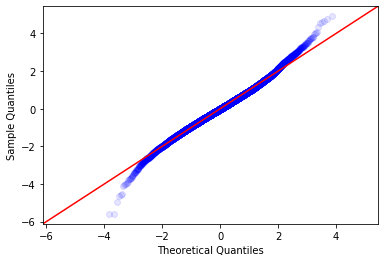

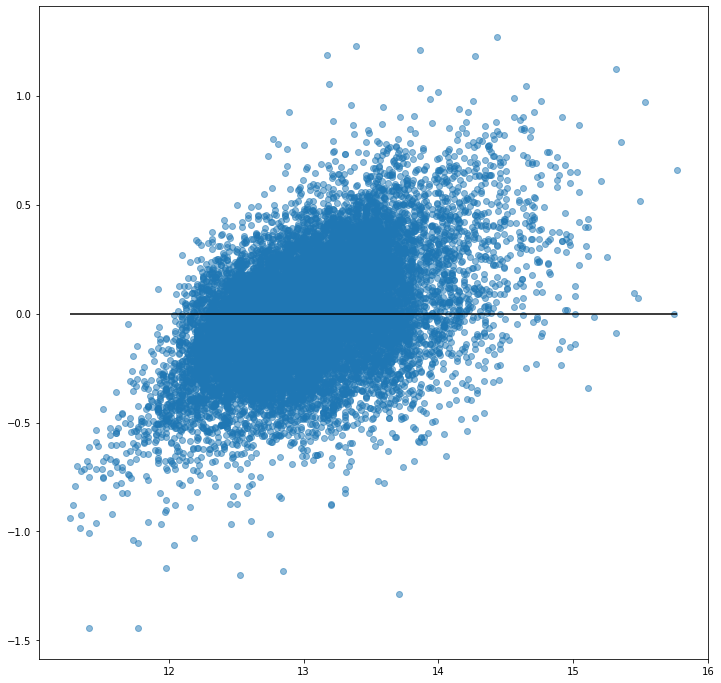

In [184]:
data = pd.read_csv('data/clean.csv')
#data = data[data.price < 2000000]

data.sort_index(axis=1, inplace=True)
data_train, data_test = tts(data, train_size=0.8, random_state=111)
data_train = data_train.reset_index().drop('index', axis=1)

multicollinearity_threshold=0.7
alpha=0.05


data_t = transform(data_train, poly='all')

outcome = 'price'
x_cols = [col for col in (data_t.drop([outcome], axis=1).columns) 
                    if isinstance(data_t[col][0], numbers.Number)]

x_cols, pvalues = stepwise_selector(data_t, x_cols, alpha=alpha)

x_cols = multicoll_remove(data_t, x_cols, pvalues, multicollinearity_threshold)
x_cols, pvalues = stepwise_selector(data_t, x_cols)

predictors = '+'.join(x_cols)
f = 'price' + '~' + predictors
results = ols(formula=f, data=data_t).fit()

metrics(data_t, results, x_cols)
results.summary()



In [113]:
results.summary()

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     5399.
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:31:33   Log-Likelihood:                -2496.1
No. Observations:               16987   AIC:                             5010.
Df Residuals:                   16978   BIC:                             5080.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               50.6531      1.235     41.010      0.000      48.232      53.074
price__sqft_basement -1.626e-10   6.06e-12    -26.818      0.000   -1.74e-10   -1.51e-10
bathroomsx4_26        9.055e-06   2.21e-07     40.883      0.000    8.62e-06    9.49e-06
price__sqft_living15  2.612e-10   3.47e-12     75.338      0.000    2.54e-10    2.68e-10
sqft_lot15_pow_2      7.191e-11   5.54e-12     12.969      0.000     6.1e-11    8.28e-11
sqft_living              0.4876      0.008     63.196      0.000       0.473       0.503
price__sqft_lot15     1.278e-12   5.41e-13      2.361      0.018    2.17e-13    2.34e-12
sqft_lot15              -0.1645      0.004    -38.253      0.000      -0.173      -0.156
yr_built                -5.2939      0.165    -32.113      0.000      -5.617      -4.971
bathroomsx4_25                0          0        nan        nan           0           0
sqft_basement            0.0131      0.001     14.799      0.000       0.011       0.015
==============================================================================
Omnibus:                     4924.056   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59919.383
Skew:                          -1.045   Prob(JB):                         0.00
Kurtosis:                      11.960   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [152]:
len(data)

21234

In [127]:
len(results.resid)

16987

ValueError: x and y must be the same size

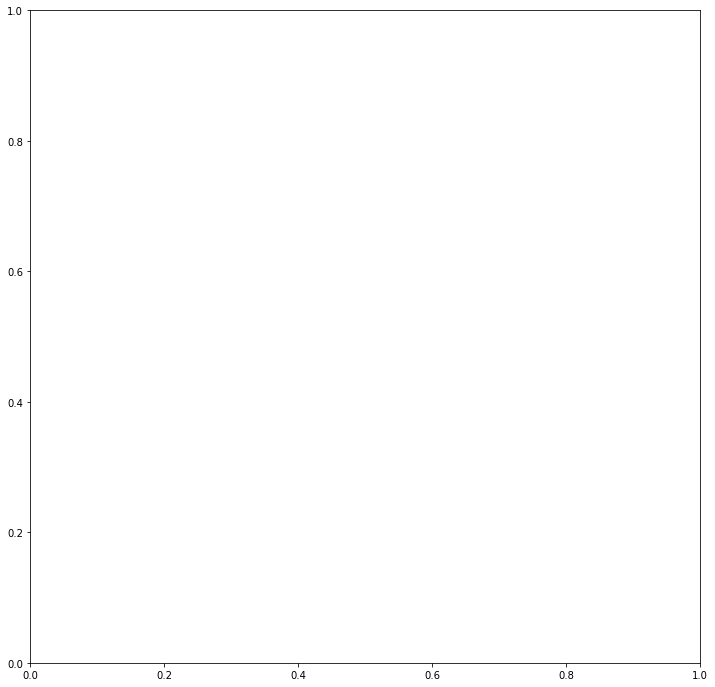

In [120]:
fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45',
                         fit=True, alpha=0.1)

fig = plt.figure(figsize=(12,12))
plt.scatter(data.price, results.resid, alpha=0.5);
plt.hlines(0, xmax=data.price.max(), xmin=data.price.min());    

In [168]:
data_t

,date,lat,long,price,waterfront,zipcode,sqft_above,sqft_basement,sqft_living,sqft_living15,...,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_1,view_2,view_3,view_4
0,2014-10-13,47.5112,-122.257,12.309982,0.0,98178.0,7.640123,5.634790,7.766417,7.951559,...,0,0,0,0,0,0,0,0,0,0
1,2014-12-09,47.7210,-122.319,13.195614,0.0,98125.0,7.989560,7.244228,8.377931,8.095599,...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,7.170120,4.867534,7.265430,7.467371,...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,7.841493,0.000000,7.841493,7.765569,...,0,0,0,0,0,0,0,0,0,0
4,2015-02-18,47.6168,-122.045,13.142166,0.0,98074.0,7.162397,0.000000,7.162397,7.162397,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21229,2014-05-21,47.6993,-122.346,12.793859,0.0,98103.0,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
21230,2015-02-23,47.5107,-122.362,12.899220,0.0,98146.0,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
21231,2014-06-23,47.5944,-122.299,12.904459,0.0,98144.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
21232,2015-01-16,47.5345,-122.069,12.899220,0.0,98027.0,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [176]:
data = pd.read_csv('data/clean.csv')
#data = data[data.price < 2000000]

data.sort_index(axis=1, inplace=True)
data_train, data_test = tts(data, train_size=0.8, random_state=111)
multicollinearity_threshold=0.7

#data_t = data.copy()
# data_t = transform(data_train)
data_train = data_train.reset_index().drop('index', axis=1)
data_train

,bathroomsx4,bedrooms,condition,date,floorsx2,grade,lat,long,price,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode
0,9,3,4,2014-10-01,4,8,47.6170,-122.288,1330000.0,2080,280,2360,2840,5504,5470,0,0,1913,1913,98122
1,12,5,3,2014-08-27,4,10,47.6518,-122.160,900000.0,2950,1400,4350,3280,37169,41631,0,0,1972,1972,98005
2,4,2,3,2014-06-12,3,7,47.6415,-122.303,620000.0,1300,130,1430,1750,3000,4000,0,0,1929,1929,98112
3,10,4,3,2015-03-31,4,9,47.3410,-122.179,415000.0,2544,0,2544,2358,4071,4179,0,0,2013,2013,98030
4,4,2,3,2015-04-29,4,7,47.6972,-122.025,300000.0,1290,0,1290,1290,2482,2482,0,0,2008,2008,98053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16982,9,5,5,2014-12-09,4,7,47.6757,-122.309,678940.0,1750,860,2610,2160,4080,4080,0,0,1909,1909,98115
16983,10,3,3,2014-05-16,4,9,47.5458,-121.996,619500.0,2170,0,2170,2170,5000,5000,0,0,2003,2003,98029
16984,6,3,3,2015-04-22,2,7,47.4729,-122.301,278000.0,1120,780,1900,1900,9994,9994,0,0,1960,1960,98168
16985,10,4,3,2014-11-18,4,10,47.5598,-122.018,645500.0,2390,0,2390,2630,9638,9258,0,0,1988,1988,98029
